# 1D convection - diffusion equation
## Finite volume approach

### Flow with a constant velocity

La variable scalaire $\Phi$ est transportée par convection et diffusion dans un écoulement à vitesse constante et connue ($u$) traversant un domaine mono-dimensionnel, voir la figure ci-dessous où figurent les conditions limites du problème. 

La solution analytique du problème s'écrit 
$ \dfrac{\Phi -\Phi_A}{\Phi_B -\Phi_A}  = \left({\exp{\left(\dfrac{\rho u x}{\Gamma}\right)} -1} \right) / \left({\exp{\left(\dfrac{\rho u L}{\Gamma}\right)} -1} \right)$

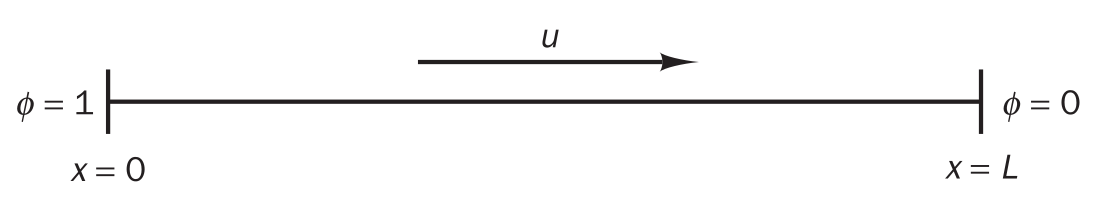

In [1]:
from IPython.display import display, Image, Math
i=Image(filename='fig/diff_conv_exemple.png', width=600)
display(i)

Soit à résoudre le problème de transport 1D par convection-diffusion 

$  \dfrac{d}{dx}(\rho u \Phi) =  \dfrac{d}{dx} \left( \Gamma \frac{d\Phi}{dx} \right) \quad \textrm{pour} \quad 0<x<L,
  \textrm{avec} \quad \Phi(x=0)=\Phi_A=1, \quad \Phi(x=L)=\Phi_B=0 $
  
On utilisera un maillage décalé **régulier** à faces centrées, tout d'abord à 5 volumes de contrôle.

In [2]:
i=Image(filename='fig/dessin.png', width=600)
display(i)

In [3]:
# python packages
import sys
sys.path.append('src')
get_ipython().run_line_magic('matplotlib', 'inline')

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

np.set_printoptions(linewidth=130)

In [4]:
# source files
from grid_module import *            # mesh 
from properties_module import *      # physical properties definition
from solver_module import *          # operators
from bc_module import *              # boundary conditions    Gamx = gamma_x * np.ones (dim_sca)

 # 1. Set the problem parameters: boundary conditions and mesh

In [5]:
# physical parameters
Lx = 1.
xstart = 0 ; xend = Lx 
Ly = 1.
ystart = 0 ; yend = 1.

Uval    = 0.2          # 0.1 2.5 -0.1 -2.5
rhoval  = 1.
gamma_x = .1

# boundary conditions
C0 = 1    # BC x = 0 at A
CL = 0    # BC x = L at B
U0 = Uval # BC x = 0
UL = Uval # BC x = L

In [6]:
## Mesh

# number of inner nodes  = number of unknowns
m = 5               # F-V number (5 10 50)

# 1D test case
n = 1

# Numerical grid for the fluid
x = reg_grid(m, xstart, xend)     # x: velocity positions
y = reg_grid(n, ystart, yend)     # x: velocity positions

# Mesh and sizes of variables on inner nodes
dx, xp, dim_sca,   dxp, xu, dim_U, dxu = coordinates(m, x)
dy, yp, dim_sca_y, dyp, yv, dim_V, dyv = coordinates(n, y)

# 1D test case
print('x :  ',  x, '\n y  : ',  y)
print('xp : ', xp, '\n yp : ', yp)
print('xu : ', xu, '\n yv : ', yv)

x :   [0.  0.2 0.4 0.6 0.8 1. ] 
 y  :  [0. 1.]
xp :  [0.1 0.3 0.5 0.7 0.9] 
 yp :  [0.5]
xu :  [0.2 0.4 0.6 0.8] 
 yv :  []


<Figure size 432x288 with 0 Axes>

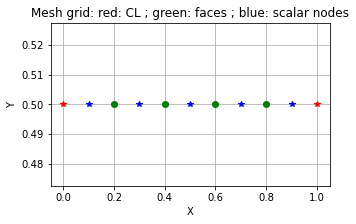

In [7]:
# figure

plt.figure()
XCL, YCL = np.meshgrid(x,  yp)
XU,   YU = np.meshgrid(xu, yp)
XP,   YP = np.meshgrid(xp, yp)

fig = plt.figure(figsize=(5,3))
plt.plot(XCL, YCL, 'r*');
plt.plot(XU,   YU, 'go');
plt.plot(XP,   YP, 'b*');

plt.title("Mesh grid: red: CL ; green: faces ; blue: scalar nodes")
plt.xlabel("X")
plt.ylabel('Y')

plt.grid(True)

plt.show()

# 2. Plot and print the exact solution on the scalar mesh

In [8]:
def Cexact(x):
    
    """ x : position """
    
    f = C0 + (CL-C0) * (np.exp(rhoval*Uval*x/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)
    
    return f

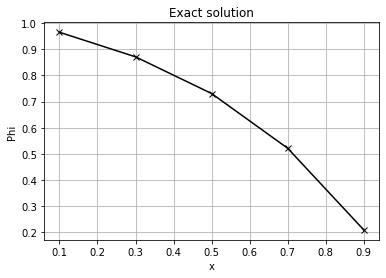

xp(  0  ) =  0.10,   Cexact (  0  ) = 0.965346562
xp(  1  ) =  0.30,   Cexact (  1  ) = 0.871323903
xp(  2  ) =  0.50,   Cexact (  2  ) = 0.731058579
xp(  3  ) =  0.70,   Cexact (  3  ) = 0.521807303
xp(  4  ) =  0.90,   Cexact (  4  ) = 0.209641082


<Figure size 432x288 with 0 Axes>

In [9]:
sol_exact = Cexact(xp)

fig = plt.figure()
plt.plot(xp, sol_exact,'kx-')

plt.title( "Exact solution" )
plt.xlabel('x')
plt.ylabel('Phi')

plt.grid(True)

plt.show()

# --------------------------------

plt.savefig('Figures/Cexacte.png')

for j in range(0,np.size(sol_exact)):
    print('xp({0:3d}  ) =  {1:3.2f},   Cexact ({0:3d}  ) = {other:7.9f}'.format(j,xp[j], other=sol_exact[j]))

# 3. Calculate the physical properties on the velocity mesh

In [10]:
# physical properties estimated on the VF faces

Gamx_ew, rho_ew = prop_phys(dim_sca, dim_U, gamma_x, rhoval)

print(np.shape(Gamx_ew))

(4, 1)


# 4. Solve the 1D convective-diffusive problem

In [11]:
# declarations

matA = np.eye(m)                    # the whole matrix including inner nodes and BC nodes
BB   = np.zeros((m-2,m))   # diffusive part of matA
bcW  = np.zeros((1,  m))   # BC row of matA
bcE  = np.zeros((1,  m))   # BC row of matA

source = np.zeros(dim_sca)          # source vector
SbcW,  SbcE = 0., 0.                # BC elements of Source

# Quick
SbcW0   , SbcW1   = 0., 0.
SbcEN_1 , SbcEN_2 = 0., 0.

bcW0    = np.zeros((1,  m))   # BC row of matA
bcW1    = np.zeros((1,  m))   # BC row of matA

bcEN_1  = np.zeros((1,  m))   # BC row of matA
bcEN_2  = np.zeros((1,  m))   # BC row of matA

# ---------------------------------------------

# Ux : vector at the VF faces
Ux = Uval * np.ones(dim_U)

# scalar interpolation at FV interfaces
#cname = 'centred'
#cname = 'upwind'
#cname = 'hybrid'
cname = 'quick'

In [12]:
### matrix construction

mass = sp.diags([dy], [0], (m, m)).toarray() #dy - diagonal matrix

#### Diffusion
Div, Grad = gradiv(m, dxp) # divergence, gradient
BB = mass[1:-1,1:-1]@(Div@(Gamx_ew * Grad))

# ---------------------------------------

# Reynolds number

R = rho_ew * Ux * (dxp.reshape(Ux.shape)) / Gamx_ew

# ---------------------------------------

#### Convection

if cname == 'centred':
    print ('centred scheme')
    Int = interp(m)              # centred interpolation
    
elif cname == 'upwind':
    print ('upwind scheme')
    Int = upwind(m, Ux)          # upwind interpolation
    
elif cname == 'hybrid':          # hybrid interpolation
    print ('hybrid scheme')
    
    Int = (np.abs(R) < 2)  * interp(m) + (np.abs(R) >= 2) * upwind(m, Ux)     # centred interpolation  
    BB  = np.zeros((m-2,m))
    BB  = mass[1:-1,1:-1]@(Div@((np.abs(R) < 2)*Gamx_ew * Grad)) # Diffusive term associated to D (Gamma/dx)

elif cname == 'quick':
    print ('quick scheme')
    Int = quick(m, Ux)           # quick interpolation
    
else:
    sys.exit("Error cname")
    
# ---------------------------------------

AA = mass[1:-1,1:-1]@(Div@(rho_ew*Ux*Int))

#### the full matrix   

matA[1:-1,:] = AA-BB
matA

quick scheme


array([[ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.675,  1.075, -0.425,  0.   ,  0.   ],
       [ 0.025, -0.675,  1.075, -0.425,  0.   ],
       [ 0.   ,  0.025, -0.675,  1.075, -0.425],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  1.   ]])

In [13]:
### boundary conditions

# Upwind/Hybride
bcW[0, 1] = matA[1,  2]  # a_E unchanged
bcE[0,-2] = matA[-2,-3]  # a_W unchanged
bcW[0, 0] = matA[1,  1]  # a modifier par bc
bcE[0,-1] = matA[-2,-2]  # a modifier par bc

# Quick
bcW0[0,0]    = 0
bcW0[0,1]    = 0
bcW1[0,0]    = 0

bcEN_1[0,-1] = 0
bcEN_1[0,-2] = 0
bcEN_2[0,-1] = 0

if cname == 'centred' or cname == 'upwind' or cname == 'hybrid':
    bcW, bcE, SbcW, SbcE = bc_diff(bcW, bcE, SbcW, SbcE, m, x, xp, dxp, C0, CL, gamma_x, Gamx_ew, mass)

elif cname == 'quick':
    bcW0, bcEN_1,  SbcW0, SbcEN_1 = bc_diff_quick(bcW0, bcEN_1,  SbcW0, SbcEN_1, m, x, xp, dxp, C0, CL, gamma_x, Gamx_ew, mass, dx)
    
else:
    print('error in cname')

# ------------------------------------------------------------------------------

if cname == 'centred':
    bcW, bcE, SbcW, SbcE = bc_interp(bcW, bcE, SbcW, SbcE, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass)

elif cname == 'upwind': 
    bcW, bcE, SbcW, SbcE = bc_upwind(bcW, bcE, SbcW, SbcE, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass)

elif cname == 'hybrid':
    bcW, bcE, SbcW, SbcE = bc_hybrid(bcW, bcE, SbcW, SbcE, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass, dx, Gamx_ew)

elif cname == 'quick' :
    bcW0, bcW1, bcEN_1, bcEN_2,  SbcW0, SbcW1, SbcEN_1, SbcEN_2 = bc_quick(bcW0, bcW1, bcEN_1, bcEN_2,  SbcW0, SbcW1, SbcEN_1, SbcEN_2, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass)
    
else:
    1==0

# ------------------------------------------------------------------------------

# assembling
if cname == 'centred' or cname == 'upwind' or cname == 'hybrid':
    matA       = np.concatenate((bcW[:], matA[1:-1,:], bcE[:]), axis=0)
    source[0]  = SbcW
    source[-1] = SbcE
    
elif cname == 'quick':
    matA        = np.concatenate((bcW0[:], matA[1:-1,:], bcEN_1[:]), axis=0)

    matA[1,0]   += bcW1[0,0]/8
    matA[-2,-1] += bcEN_2[0,-1]/8

    source[0]  = -SbcW0
    source[1]  = -SbcW1
    source[-2] = -SbcEN_2
    source[-1] = -SbcEN_1
    
else:
    print('error in cname')
    
print(matA)
print(source)

[[ 2.175      -0.59166667  0.          0.          0.        ]
 [-0.7         1.075      -0.425       0.          0.        ]
 [ 0.025      -0.675       1.075      -0.425       0.        ]
 [ 0.          0.025      -0.675       1.075      -0.425     ]
 [ 0.          0.          0.025      -0.81666667  1.925     ]]
[[ 1.58333333]
 [-0.05      ]
 [ 0.        ]
 [-0.        ]
 [-0.        ]]


In [14]:
### Resolution by a sparse solver: spsolve

# initialisation of solution field
c_sol     = np.ones(shape=m+2)
c_sol[0]  = C0
c_sol[-1] = CL

# solver
CC = sp.csr_matrix(matA)
c_sol[1:-1] = spsolve(CC, source)

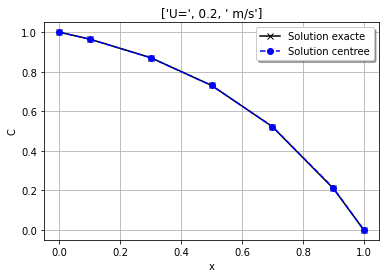

xtot(  0  ) =  0.00,   c_VF (  0  ) = 1.000000000,   Cexact (  0  ) = 1.000000000
xtot(  1  ) =  0.10,   c_VF (  1  ) = 0.964825962,   Cexact (  1  ) = 0.965346562
xtot(  2  ) =  0.30,   c_VF (  2  ) = 0.870698256,   Cexact (  2  ) = 0.871323903
xtot(  3  ) =  0.50,   c_VF (  3  ) = 0.730876357,   Cexact (  3  ) = 0.731058579
xtot(  4  ) =  0.70,   c_VF (  4  ) = 0.522568023,   Cexact (  4  ) = 0.521807303
xtot(  5  ) =  0.90,   c_VF (  5  ) = 0.212203624,   Cexact (  5  ) = 0.209641082
xtot(  6  ) =  1.00,   c_VF (  6  ) = 0.000000000,   Cexact (  6  ) = 0.000000000


In [15]:
# FIGURE #
xtot        = np.ones(shape=m+2)
xtot[1:m+1] = xp
xtot[0]     = xstart
xtot[-1]    = xend

Cexact = C0 + (CL-C0) * (np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)

# ------------------------------

plt.figure()
plt.plot(xtot, Cexact,'kx-')
plt.plot(xtot, c_sol,'bo--')

plt.title(['U=', Uval, ' m/s'])
plt.xlabel('x')
plt.ylabel('C')

plt.legend(('Solution exacte', 'Solution centree'), loc='best', shadow=True)
plt.grid(True)

# ------------------------------

plt.show()

for j in range(0,np.size(Cexact)):
        print('xtot({0:3d}  ) =  {1:3.2f},   c_VF ({0:3d}  ) = {2:7.9f},   Cexact ({0:3d}  ) = {other:7.9f}'.format(j,xtot[j],c_sol[j],other=Cexact[j]))

# Conv rate - precision order

This part will aim in calculating and thus demonstrating from the code the expected order of precision.

It has been made using a KTH (Stockholm University) paper called **Verifying Numerical Convergence Rates**. This document that you have attached to this report, explains how to calculate the convergence rate of a step (space or time step) given a solution in a given point.

This method has then been adapted to our case and applied in following blocks.

However, before going through numerical calculations, we are to demonstrate analytically the expected convergence rate ($\equiv$ precision order) : 
- order 1 for upwind scheme
- order 2 for centered scheme
- order 2 for quick scheme ??

#### $\underline{Upwind}$

$$ \phi(x+\Delta x) = \phi(x) + \Delta x \phi'(x) + o(\Delta x ^2)$$

Therfore for upwind, we get that :
    
$$\phi(x) = \phi(x+\Delta x) + o(\Delta x)$$

such that the scheme is of **order 1**.

#### $\underline{Centered}$

$$\phi(x+\Delta x) = \phi(x) + \Delta x\phi'(x) + o(\Delta x ^2)$$

$$ \text{&} $$

$$\phi(x-\Delta x) = \phi(x) - \Delta x\phi'(x) + o(\Delta x ^2)$$

Thus :

$$\phi(x+\Delta x) + \phi(x-\Delta x) = 2\phi(x) + o(\Delta x ^2)$$

and so :

$$\phi(x) = \dfrac{\phi(x+\Delta x) + \phi(x-\Delta x)}{2} + o(\Delta x ^2)$$

such that the scheme is of **order 2**.

$\underline{Quick}$ 

For what is up to quick we are to get precision numerically as we don't have detail on how it was obtaines.

### Numerical precision order

Let's now derive introduced method for the numerical scheme. You'll have to choose on wether you want to test centered or upwind scheme :

In [16]:
# ON WHAT SCHEME DO YOU WANT TO TEST CONVERGENCE RATE ?? WORKS ONLY FOR HYBRID CNAME AS IT USES CENTERED AND UPWIND

# 0 = upwind
# 1 = centered

scheme = 1  # change here

In [17]:
def Cexact(x):
    
    """ x : position """
    
    f = C0 + (CL-C0) * (np.exp(rhoval*Uval*x/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)
    
    return f

# ------------------------

## Mesh

# number of inner nodes  = number of unknowns
nb_m = 10
M    = np.array([2**(i+2) for i in range(nb_m)])  #i+2 so that at i=0 ==> 2**2 = 4             # F-V number (5 10 50)

# 1D test case
n = 1

# ------------------------

# scalar interpolation at FV interfaces
#cname = 'centred'
#cname = 'upwind'
cname = 'hybrid'
#cname = 'quick'

# ------------------------

# Vector to stock variables
phi  = np.zeros((1,2))
phi2 = np.zeros((1))

# ------------------------

for m in M:

    # --------------------------------------------------------
    # ------------------------- Mesh -------------------------
    # --------------------------------------------------------
    
    # physical parameters
    Lx = 1.
    xstart  = 0 ; xend = Lx 
    Ly = 1.
    ystart  = 0 ; yend = 1.

    Uval    = 2.5          # 0.1 2.5 -0.1 -2.5
    rhoval  = 1.
    gamma_x =  .1

    # boundary conditions
    C0 = 1    # BC x = 0 at A
    CL = 0    # BC x = L at B
    U0 = Uval # BC x = 0
    UL = Uval # BC x = L

    # ---------------------------------------

    # Numerical grid for the fluid
    x = reg_grid(m, xstart, xend)     # x: velocity positions
    y = reg_grid(n, ystart, yend)     # x: velocity positions

    # Mesh and sizes of variables on inner nodes
    dx, xp, dim_sca,   dxp, xu, dim_U, dxu = coordinates(m, x)
    dy, yp, dim_sca_y, dyp, yv, dim_V, dyv = coordinates(n, y)

    # --------------------------------------------------------

    ## physical properties estimated on the VF faces
    Gamx_ew, rho_ew = prop_phys(dim_sca, dim_U, gamma_x, rhoval)

    # --------------------------------------------------------
    # ------------ Matrix/Vectors Inititalisation ------------
    # --------------------------------------------------------
    
    ## Matrices & vectors - Initialisation
    matA   = np.eye(m)                    # the whole matrix including inner nodes and BC nodes
    BB     = np.zeros((m-2,m))  # diffusive part of matA
    bcW    = np.zeros((1,  m))   # BC row of matA
    bcE    = np.zeros((1,  m))   # BC row of matA

    source = np.zeros(dim_sca)          # source vector
    SbcW,  SbcE = 0., 0.                # BC elements of Source

    # Quick
    SbcW0   , SbcW1   = 0., 0.
    SbcEN_1 , SbcEN_2 = 0., 0.

    bcW0    = np.zeros((1,  m))   # BC row of matA
    bcW1    = np.zeros((1,  m))   # BC row of matA

    bcEN_1  = np.zeros((1,  m))   # BC row of matA
    bcEN_2  = np.zeros((1,  m))   # BC row of matA

    # ---------------------------------------------

    # Ux : vector at the VF faces
    Ux     = Uval * np.ones(dim_U)

    # --------------------------------------------------------
    # -------------- Matrix/Vectors Construction -------------
    # --------------------------------------------------------

    mass = sp.diags([dy], [0], (m, m)).toarray() #dy - diagonal matrix

    # ---------------------------------------

    # Reynolds number
     
    if scheme == 0: #Test on upwind precision order
        R = 5
    elif scheme == 1: #Test on centered precision order
        R = rho_ew * Ux * (dxp.reshape(Ux.shape)) / Gamx_ew
    else:
        print('Check value you gave for scheme precision')
        exit
        
    # --------------------------------------------------------
    # --------------------- Diffusion ------------------------
    # --------------------------------------------------------
    
    Div, Grad = gradiv(m, dxp) # divergence, gradient
    BB = mass[1:-1,1:-1]@(Div@(Gamx_ew * Grad))
    
    # --------------------------------------------------------
    # --------------------- Convection -----------------------
    # --------------------------------------------------------
    
    if cname == 'centred':
        Int = interp(m)              # centred interpolation

    elif cname == 'upwind':
        Int = upwind(m, Ux)          # upwind interpolation

    elif cname == 'hybrid':          # hybrid interpolation
        Int = (np.abs(R) < 2)  * interp(m) + (np.abs(R) >= 2) * upwind(m, Ux)     # centred interpolation  
        BB  = np.zeros((m-2,m))
        BB  = mass[1:-1,1:-1]@(Div@((np.abs(R) < 2)*Gamx_ew * Grad)) # Diffusive term associated to D (Gamma/dx)

    elif cname == 'quick':
        Int = quick(m, Ux)           # quick interpolation

    else:
        sys.exit("Error cname")

    # ---------------------------------------

    AA = mass[1:-1,1:-1]@(Div@(rho_ew*Ux*Int))

    # the full matrix   
    matA[1:-1,:] = AA-BB
    
    # --------------------------------------------------------
    # ---------------- boundary conditions -------------------
    # --------------------------------------------------------

    bcW[0, 1] = matA[1,  2]  # a_E unchanged
    bcE[0,-2] = matA[-2,-3]  # a_W unchanged
    bcW[0, 0] = matA[1,  1]  # a modifier par bc
    bcE[0,-1] = matA[-2,-2]  # a modifier par bc

    
    # Quick
    bcW0[0,0]    = 0
    bcW0[0,1]    = 0
    bcW1[0,0]    = 0

    bcEN_1[0,-1] = 0
    bcEN_1[0,-2] = 0
    bcEN_2[0,-1] = 0

    if cname == 'centred' or cname == 'upwind' or cname == 'hybrid':
        bcW, bcE, SbcW, SbcE = bc_diff(bcW, bcE, SbcW, SbcE, m, x, xp, dxp, C0, CL, gamma_x, Gamx_ew, mass)

    elif cname == 'quick':
        bcW0, bcEN_1,  SbcW0, SbcEN_1 = bc_diff_quick(bcW0, bcEN_1,  SbcW0, SbcEN_1, m, x, xp, dxp, C0, CL, gamma_x, Gamx_ew, mass, dx)

    else:
        print('error in cname')

    # ------------------------------------------------------------------------------

    if cname == 'centred':
        bcW, bcE, SbcW, SbcE = bc_interp(bcW, bcE, SbcW, SbcE, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass)

    elif cname == 'upwind': 
        bcW, bcE, SbcW, SbcE = bc_upwind(bcW, bcE, SbcW, SbcE, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass)

    elif cname == 'hybrid':
        bcW, bcE, SbcW, SbcE = bc_hybrid(bcW, bcE, SbcW, SbcE, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass, dx, Gamx_ew)

    elif cname == 'quick' :
        bcW0, bcW1, bcEN_1, bcEN_2,  SbcW0, SbcW1, SbcEN_1, SbcEN_2 = bc_quick(bcW0, bcW1, bcEN_1, bcEN_2,  SbcW0, SbcW1, SbcEN_1, SbcEN_2, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass)

    else:
        1==0

# ------------------------------------------------------------------------------

    # assembling
    if cname == 'centred' or cname == 'upwind' or cname == 'hybrid':
        matA       = np.concatenate((bcW[:], matA[1:-1,:], bcE[:]), axis=0)
        source[0]  = SbcW
        source[-1] = SbcE

    elif cname == 'quick':
        matA        = np.concatenate((bcW0[:], matA[1:-1,:], bcEN_1[:]), axis=0)

        matA[1,0]   += bcW1[0,0]/8
        matA[-2,-1] += bcEN_2[0,-1]/8

        source[0]  = -SbcW0
        source[1]  = -SbcW1
        source[-2] = -SbcEN_2
        source[-1] = -SbcEN_1

    else:
        print('error in cname')
    
    # --------------------------------------------------------
    # -------- Resolution by a sparse solver: spsolve --------
    # --------------------------------------------------------
    
    # Numerical solution

    # initialisation of solution field
    c_sol     = np.ones(shape=m+2)
    c_sol[0]  = C0
    c_sol[-1] = CL

    # solver
    CC = sp.csr_matrix(matA)
    c_sol[1:-1] = spsolve(CC, source)

    # ---------------------------------
    
    # Exact solution

    xtot        = np.ones(shape=m+2)
    xtot[1:m+1] = xp
    xtot[0]     = xstart
    xtot[-1]    = xend

    Cexact = C0 + (CL-C0) * (np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)

    # --------------------------------------------------------
    # ----------------- Save each solution -------------------
    # --------------------------------------------------------

    phi  = np.append(phi,  [[c_sol[-2], Cexact[-2]]], axis=0)
    phi2 = np.append(phi2, [c_sol[-2]])

In [18]:
# log2(u_h - u / u_h/2 - u2) (u2 == u associated to u_h/2 as u changes with m changing)

# Method 1

ratio = np.zeros((np.size(M)-1))
rate  = np.zeros((np.size(M)-1))

for i in range(np.size(M)-1):
    ratio[i] = np.abs((phi[i+1,0] - phi[i+1,1])/(phi[i+2,0] - phi[i+2,1]))
    rate[i]  = np.log2(ratio[i])
    
print(rate)

[ 0.13598915 -0.40445612  1.8297178   1.91056561  1.95417206  1.97680381  1.9883308   1.99414755  1.99706931]


In [19]:
# Method 2

ratio2 = np.zeros((np.size(M)-2))
rate2  = np.zeros((np.size(M)-2))

for i in range(np.size(M)-2):
    ratio2[i] = np.abs((phi2[i+1] - phi2[i+2])/(phi2[i+2] - phi2[i+3]))
    rate2[i]  = np.log2(ratio[i])

print(rate2)

[ 0.13598915 -0.40445612  1.8297178   1.91056561  1.95417206  1.97680381  1.9883308   1.99414755]


#### $\underline{\text{Balance sheet convergence rate}}$

$\Rightarrow$ As you can see when testing schemes, the **order of precision** are **as expected** (for centered and upwind especially). You can find the **numerical association in the rate vectors (i.e. rate & rate2)**.
The rate convergences to expected results, **demonstrating convergence rate** (i.e. **order 1 for upwind** and **2 for centered**).

For what is up to **quick scheme**, the process used here proves it's of **order 3** (at least for considered Reynold number).

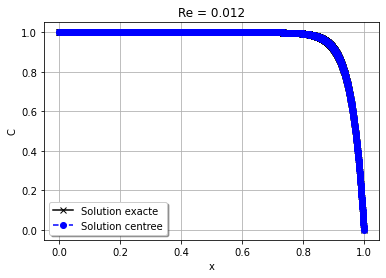

In [27]:
# FIGURE #
xtot        = np.ones(shape=m+2)
xtot[1:m+1] = xp
xtot[0]     = xstart
xtot[-1]    = xend

Cexact = C0 + (CL-C0) * (np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)

# ------------------------------

plt.figure()
plt.plot(xtot, Cexact,'kx-')
plt.plot(xtot, c_sol,'bo--')

plt.title(f'Re = {R[0,0]:.3f}')
plt.xlabel('x')
plt.ylabel('C')

plt.legend(('Solution exacte', 'Solution centree'), loc='best', shadow=True)
plt.grid(True)

plt.show()

### Stability illustration

In order to **illustrate accurately the stability of the schemes**, and knowing the overall behavior depending on Re, we are **to test three schemes for a high speed** and therefore **see** the **limits of the schemes** used.

##### Upwind

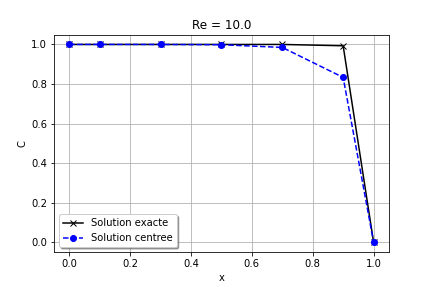

In [21]:
i=Image(filename='Figures/stability_upwind.png', width=600)
display(i)

##### Hybrid

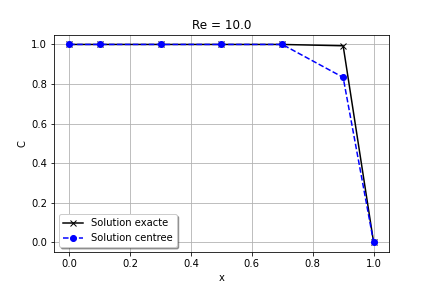

In [22]:
i=Image(filename='Figures/stability_hybrid.png', width=600)
display(i)

##### Quick

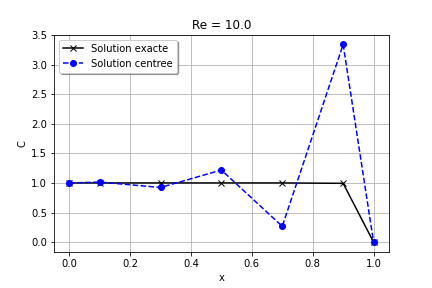

In [23]:
i=Image(filename='Figures/stability_quick.png', width=600)
display(i)

$\Rightarrow$ **For the same Re, we firstly see hybrid and upwind scheme behaves the same. It's in fact due to the fact that hybrid scheme uses upwind scheme for high speed. Thereby, the first 2 illustrations show that upwind scheme is indeed stable for high Reynolds number.**

**On the other hand, Quick scheme that looked to be the most precise when looking to convergence rate appears to be non stable at high speed. This confirm our first observation that more precise scheme are more unstable.**

Too conclude on this practical homework, we are to see these observation through L2 error calculation.

### Error comparison - L2 norm

##### Upwind

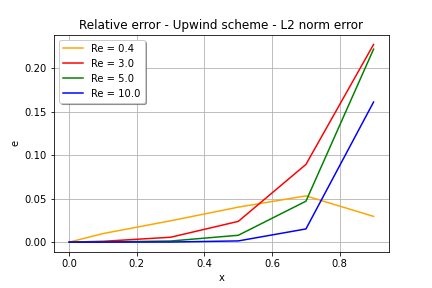

In [24]:
## Error - L2 norm

i=Image(filename='Figures/R_error_upwind.png', width=600)
display(i)

##### Hybrid

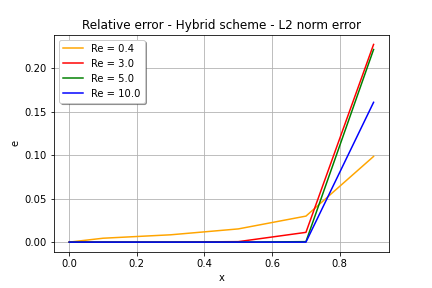

In [25]:
## Error - L2 norm

i=Image(filename='Figures/R_error_hybrid.png', width=600)
display(i)

##### Quick

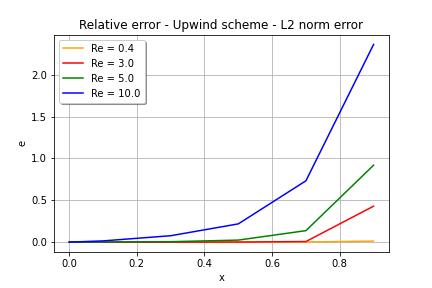

In [26]:
## Error - L2 norm

i=Image(filename='Figures/R_error_quick.png', width=600)
display(i)

For the three schemes, **higher Re, higher the error**. We may note that **the results** for $R = 5$ **depend on the number of points considered (5 here, which is probably too low)**.

However, we generally speaking, see that **upwind and hybrid schemes are of same order of precision** (normal at high speed because they share some parts of the same code) while **quick scheme is the most precise one but this  holds for low enough Reynolds only**. Then higher the Re, bigger the associated L2 error.

To conclude, one may run a similar process taking into account more points to get a better result but anyway an overall behavior appears : the schemes we used so far better work when having a low Re.

$\Rightarrow$ **As a conclusion, we developped several schemes, with each their pros and cons. Generally speaking, they all work well and we see that schemes that are the most precise theoretically, are the least stable. We then must do a compromise between accuracy and time calculation. We then may try to ptimize the code using several schemes for one resolution, as does hybrid scheme.**